# Working with Text Inputs for Classification
> Data Sources: 
 * [IMDB](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [36]:
from processing.text_cleaning import load_engine, func_examples
from processing.text_to_numbers import linguistic_features
from sklearn.model_selection import train_test_split
from datasets import Dataset
import pandas as pd
import wordninja
import re

In [37]:
import torch
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(f"Current Device: {device}")

Current Device: cuda


## Text Cleaning
> Use [Regex101](https://regex101.com/) to test out your regex patterns!

In [35]:
import re

# regex
examples = dict(
    digits="(404)894-2000",
    groups="George Burdell, born on 1990-05-15, is a Data Scientist.",
)

In [10]:
# digits
pattern = re.compile(r"\((\d{3})\)(\d{3})-(\d{4})")
search = re.compile(pattern)
match = search.search(examples['digits'])
area_code = match.group(1)
print(f'Area Code: {area_code}')

Area Code: 404


In [ ]:
# digits with group name
pattern_with_names = re.compile(r"\((?P<area_code>\d{3})\)(?P<prefix>\d{3})-(?P<line_number>\d{4})")
search = re.compile(pattern_with_names)
match = search.search(examples['digits'])
area_code = match.group('area_code')
print(f'Area Code: {area_code}')

Area Code: 404


In [12]:
pattern = r"(?P<first_name>\w+)\s(?P<last_name>\w+).*(?P<birth_year>\d{4})-(?P<birth_month>\d{2})-(?P<birth_day>\d{2}),\sis\sa\s(?P<career>.*)\."
search = re.compile(pattern)
match = search.search(examples['groups'])
print(f"Full Name: {match.group('first_name')} {match.group('last_name')}")
print(f"Date of Birth: {match.group('birth_month')}/{match.group('birth_day')}/{match.group('birth_year')}")
print(f"Career: {match.group('career')}")

Full Name: George Burdell
Date of Birth: 05/15/1990
Career: Data Scientist


> [WordNinja](https://github.com/keredson/wordninja) helps you separate conjoined words!

In [13]:
# wordninja
nlp_engine = load_engine() # Load Spacy Engine

def fix_conjoined_word(text, threshold:int=6, nlp_engine=nlp_engine):
    doc = nlp_engine(text) # Convert String to Tokens
    new_tokens = []
    for token in doc:
        token = str(token)
        if len(str(token)) > threshold: # Check only if word seems lengthy
            ninjas = wordninja.split(token)  # fix word spacing errors using module
            for ninja in ninjas:
                new_tokens.append(ninja)
        else:
            new_tokens.append(token)
    new_string = " ".join(new_tokens)
    return new_string


# Examples
examples = ["buzzbasketball", "rockguitar", "coffeecup", "loudmicrophone"]
func_examples(fix_conjoined_word, examples)

>> Examples
1) Before: buzzbasketball
   After: buzz basketball
2) Before: rockguitar
   After: rock guitar
3) Before: coffeecup
   After: coffee cup
4) Before: loudmicrophone
   After: loud microphone


> Import IMDB Dataset

## Spacy

In [14]:
imdb = pd.read_csv("data/IMDB Dataset.csv", nrows=500,)
imdb = pd.get_dummies(imdb, columns=['sentiment'],drop_first=True)
imdb.head()

,review,sentiment_positive
0,One of the other reviewers has mentioned that ...,True
1,A wonderful little production. <br /><br />The...,True
2,I thought this was a wonderful way to spend ti...,True
3,Basically there's a family where a little boy ...,False
4,"Petter Mattei's ""Love in the Time of Money"" is...",True


In [15]:
quant_data = linguistic_features(imdb, 'review', nlp_engine) # Takes about a 1 minute for 500 rows
quant_data = quant_data.drop(columns=['review'])
quant_data.head()

,sentiment_positive,ADJ,ADP,PUNCT,ADV,AUX,SYM,INTJ,CCONJ,X,...,pobj,poss,preconj,predet,prep,prt,punct,quantmod,relcl,xcomp
0,True,32,37,44,11,27,0,0,12,0,...,31,3,0,1,32,3,45,0,5,1
1,True,14,15,24,18,7,0,0,9,7,...,14,6,2,2,14,0,26,0,1,0
2,True,18,17,25,7,17,0,0,7,0,...,16,3,0,0,16,1,25,0,3,1
3,False,7,14,15,9,6,0,0,8,0,...,11,4,0,2,14,0,17,0,2,3
4,True,23,22,28,4,10,0,0,7,2,...,21,5,0,2,22,0,31,0,8,2


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

random_forest = RandomForestClassifier()
train, test = train_test_split(quant_data, test_size=0.25, random_state=0)

X_train, y_train = train.drop(columns=['sentiment_positive']), train['sentiment_positive']
X_test, y_true = test.drop(columns=['sentiment_positive']), test['sentiment_positive']

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

{'False': {'f1-score': 0.6616541353383458,
           'precision': 0.676923076923077,
           'recall': 0.6470588235294118,
           'support': 68.0},
 'True': {'f1-score': 0.6153846153846154,
          'precision': 0.6,
          'recall': 0.631578947368421,
          'support': 57.0},
 'accuracy': 0.64,
 'macro avg': {'f1-score': 0.6385193753614806,
               'precision': 0.6384615384615384,
               'recall': 0.6393188854489165,
               'support': 125.0},
 'weighted avg': {'f1-score': 0.6405552342394447,
                  'precision': 0.6418461538461538,
                  'recall': 0.64,
                  'support': 125.0}}


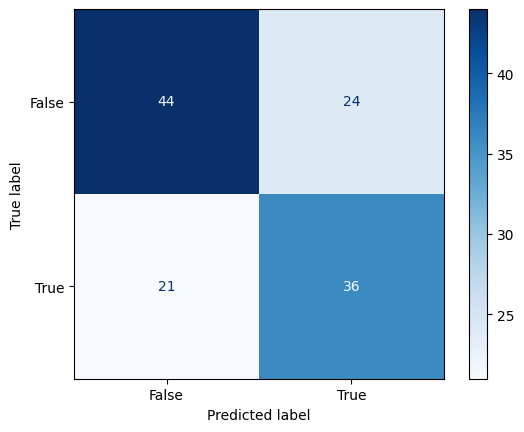

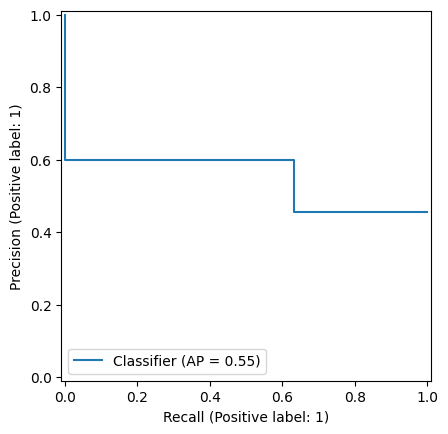

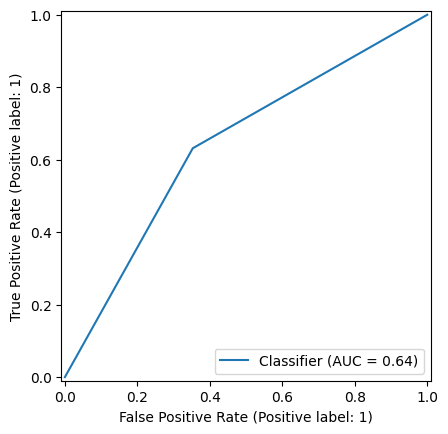

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
import pprint

report_dict = classification_report(y_true=y_true, y_pred=y_pred, output_dict=True)
pprint.pprint(report_dict)
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, cmap='Blues')
precision_recall = PrecisionRecallDisplay.from_predictions(y_true=y_true, y_pred=y_pred)
roc_curve = RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred)

## [SetFit](https://github.com/huggingface/setfit)
> SetFit is a fast and efficient text classifier that uses contrastive learning and sentence-transformer embeddings to achieve high-accuracy with only a few training examples. 

*Contrastive Learning & Fine-Tuning*
> The contrastive learning component functions by taking the training examples and building sentence pairs that create a mapping of associated sentences based on the assigned label. By creating these sentence pairs we are also generating a larger training set that gives SetFit more to work with. Using these sentences we can fine-tune the sentence-transformer embeddings to conform to our dataset by using he Euclidean Distance is gauged in the embedding space to keep similar sentences together and dissimilar sentences apart.

*When Should I Use SetFit?*
> Use SetFit when you lack sufficient annotations for any larger transfomer-based model (~1000 or less)


In [34]:
from setfit import SetFitModel, TrainingArguments, sample_dataset
from setfit import Trainer as SetFitTrainer
from datasets import Dataset

In [19]:
# Importing IMDB again
imdb = pd.read_csv("data/IMDB Dataset.csv", nrows=5000,)
imdb.head()

# Prepare Training Segments
train, dev = train_test_split(imdb, test_size=0.2, random_state=0)
evaluation, test = train_test_split(dev, test_size=0.5, random_state=0)
train.reset_index(inplace=True, drop=True)
evaluation.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# Simulate the few-shot regime by sampling examples per class
NUM_SAMPLES = 4
train_dataset = sample_dataset(Dataset.from_pandas(train, preserve_index=False), label_column="sentiment", num_samples=NUM_SAMPLES)
eval_dataset = Dataset.from_pandas(evaluation, preserve_index=False)
test_dataset = Dataset.from_pandas(test, preserve_index=False)

In [20]:
# Load a SetFit model from Hub
model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2",
    labels=["negative", "positive"],
    device=device,
)

args = TrainingArguments(
    batch_size=16,
    num_epochs=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    metric="accuracy",
    column_mapping={"review": "text", "sentiment": "label"}  # Map dataset columns to text/label expected by trainer
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

In [21]:
import joblib
import os

# Train and Evaluate
# trainer.train()
# metrics = trainer.evaluate(test_dataset)
# print(metrics)
# joblib.dump(trainer.model, "pickles/setfit.pkl")

In [22]:
# # Run inference
# preds = trainer.model.predict([
#     "i loved the spiderman movie!",
#     "paranormal activity is such a terrible movie...",
# ])
# print(preds)

## [BERT](https://huggingface.co/docs/transformers/model_doc/bert)
> BERT (or Bidirectional Encoder Representations from Transformers), is a deep learning neural network that uses

*Transformers*
> Transformers are neural network structures that have three essential properties: position, attention, & self-attention. Positional Encoding is simply the position index for a token. Attention allows a token to observe the surrounding tokens in the sentence to make a better output decision. Self-Attention contextualizes the meaning of a given token by observing the other tokens in the text and it's own use-cases (e.g. "The train passed by" vs "I want to train for a marathon").

*When Should I Use BERT?*
> When you have sufficient data (at least 1000 but preferably much more) and enough computing resources (GPU with sufficient memory)

In [23]:
from processing.bert_processing import BERTDataBuilder, BERTDataset, TrainingBERT
import yaml

In [24]:
def config_reader(stream: str):
    with open(stream, 'r') as f:
        config = yaml.safe_load(f)
    return config

config = config_reader("yaml/notebook.yaml")

In [25]:
train['sentiment'] = train['sentiment'].apply(lambda x: 1 if x == "positive" else 0)
evaluation['sentiment'] = evaluation['sentiment'].apply(lambda x: 1 if x == "positive" else 0)
test['sentiment'] = test['sentiment'].apply(lambda x: 1 if x == "positive" else 0)

In [26]:
# Data Preparation
datasets = {
    'train_dataframe':train,
    'eval_dataframe':evaluation,
    'test_dataframe':test
}
data = BERTDataBuilder(datasets=datasets, model_name="bert-base-uncased", text_column='review', label_column='sentiment')
data.build_data()

Building Datasets...
---Training Dataset...
---Validation Dataset...
---Test Dataset...


In [27]:
import warnings
# Load Trainer
# bert = TrainingBERT(data, config['train_args'])

# Training
# bert.Training()

# Evaluation
# warnings.filterwarnings("ignore", category=DeprecationWarning) 
# visuals = bert.Testing()

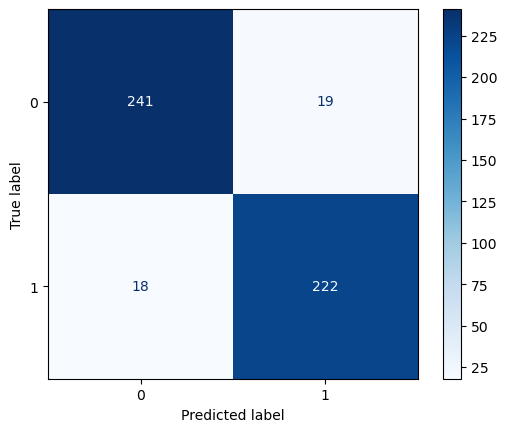

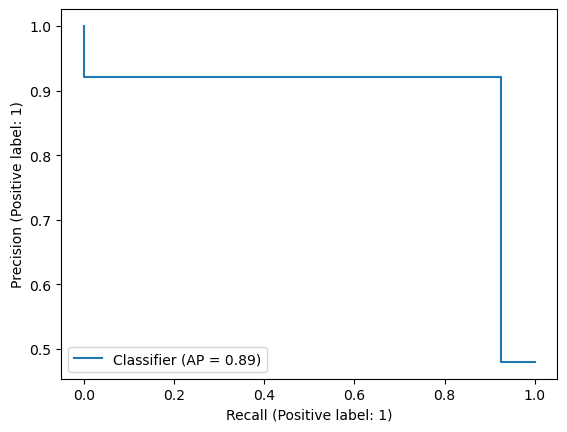

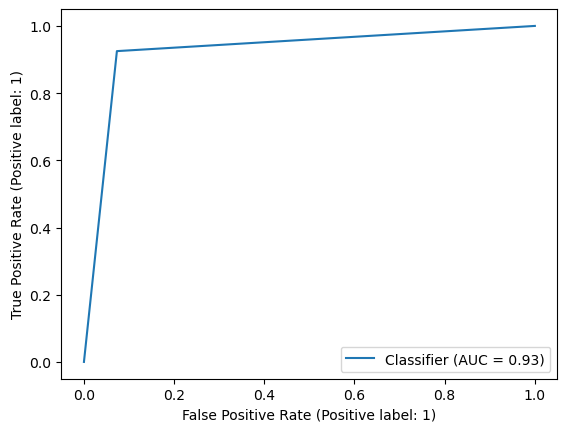

In [28]:
from IPython.display import Image, display
# Results & Visuals
display(Image(filename="bert_visuals/confusion_matrix.png"))
display(Image(filename="bert_visuals/precision_recall.png"))
display(Image(filename="bert_visuals/auc.png"))

## LLMs & Generation Constraints (w/ Langchain)

*Why Do We Need Generation Constraints*
> When you want to ensure the format of an output you may need to put "guard-rails" on how the LLM returns its responses. Constraints allow you to better curate the types of responses you receive based on your inputs.

In [38]:
from processing.llm_classification import LangchainLLM
from dotenv import load_dotenv

load_dotenv()
HUGGINGFACEHUB_API_TOKEN = os.environ['HF_API_TOKEN']
REPO_ID = os.environ['REPO_ID']

llm = LangchainLLM(repo_id=REPO_ID, hf_api_token=HUGGINGFACEHUB_API_TOKEN)

In [39]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


example = imdb.iloc[0].review
expected = True if imdb.iloc[0].sentiment == 'positive' else False

response = llm.get_response(example)

print(f">> Example: {example}\n>> Expected Result: {expected}")
print(f">> Response Received: {response.review_sentiment[0]}")

>> Example: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is du

# Literal Eval

> The ast module (abstract syntax trees) has a tool called literal_eval that can transform strings containing python objects and makes them interpretable by the script. It can handle strings, bytes, numbers, tuples, lists, dicts, sets, booleans, None, and Ellipsis.

*Why is this useful?*
> In the case where your LLM refuses to completely conform to your suggested output format, you may be able to take the pythonic strings it returns and use literal_eval to correct the output into the format you need.

In [31]:
from ast import literal_eval

# Tips and Tricks
trapped_dictionary = "{'review': [True]}"
iamfree = literal_eval(trapped_dictionary)
print(f"Content: {iamfree}\nDatatype: {type(iamfree)}")

Content: {'review': [True]}
Datatype: <class 'dict'>


In [32]:
boolean_example = 'True'
list_example = "['Hello', 'World!']"

print(f"Content: {boolean_example}\nDatatype: {type(literal_eval(boolean_example))}","\n")
print(f"Content: {list_example}\nDatatype: {type(literal_eval(list_example))}")

Content: True
Datatype: <class 'bool'> 

Content: ['Hello', 'World!']
Datatype: <class 'list'>


In [33]:
trapped_responses = "[{'review': [True]}, {'review': [False]}, {'review': [True]}]"

freed_responses = literal_eval(trapped_responses)
print(f"Highest Level: {type(freed_responses)}")
print(f"Entry Level: {type(freed_responses[0])}")
print(f"Dictionary Level: {type(freed_responses[0]['review'])}")
print(f"Value Level: {type(freed_responses[0]['review'][0])}")

Highest Level: <class 'list'>
Entry Level: <class 'dict'>
Dictionary Level: <class 'list'>
Value Level: <class 'bool'>
